<a href="https://colab.research.google.com/github/JSzJSzJSz/Media-topics-segmentation-using-large-language-models/blob/main/topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling and Similarity Calculation
This script performs topic modeling using
**jina-embeddings-v3** embedings,** UMAP + HDBSCAN** and extracts keywords using **TF-IDF**. Then, it calculates cosine similarity between topics from two datasets (WP and ON) using  embeddings.



# 1. Install Required Libraries

In [23]:
!pip install tensorflow_text datasets tensorflow_hub umap-learn hdbscan scikit-learn bertopic;

# 2. Import Dependencies

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from datasets import load_dataset
import pandas as pd
import tensorflow_hub
import tensorflow_text
import json
import umap
import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np;

# 3. Load and Preprocess Data

In [25]:


# Define dataset directories
directory_WP = "/content/drive/MyDrive/topic_modeling/data/z_radomia/WP"
directory_ON = "/content/drive/MyDrive/topic_modeling/data/z_radomia/ON"

# List available files
filenames = [os.listdir(directory_WP), os.listdir(directory_ON)]

# Load datasets
datasets = [
    load_dataset("json", data_files=[os.path.join(directory, f) for f in filenames[i]])
    for i, directory in enumerate((directory_WP, directory_ON))
]

# Preprocessing function
def preprocess(text):
    text_new = text["title"] + text["lead"] + text["text"]
    text["text"] = text_new.replace(u'\xa0', u' ').replace('Dalsza część artykułu pod materiałem wideo', u' ')
    return text

# Apply preprocessing
documents = [dataset.map(preprocess)["train"]["text"][:] for dataset in datasets]


Resolving data files:   0%|          | 0/747 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1197 [00:00<?, ?it/s]

# 4. Load Precomputed Embeddings

In [26]:
# File paths for precomputed embeddings
emb_paths = [
    "/content/drive/MyDrive/topic_modeling/embeddings_jinaai_jina-embeddings-v3_WP.json",
    "/content/drive/MyDrive/topic_modeling/embeddings_jinaai_jina-embeddings-v3_ON.json"
]

# Load embeddings
embeddings = [json.load(open(emb_paths[i])) for i in range(2)]


# 5. Dimensionality Reduction with UMAP
Parameters choice UMAP + HDBSCAN: based on grid search, final criterion for desired number of clusters & silhouette score

In [27]:
# UMAP parameters for each dataset
umap_params = [
    {'n_neighbors': 5, 'n_components': 40, 'min_dist': 0.0, 'metric': 'cosine'},
    {'n_neighbors': 8, 'n_components': 20, 'min_dist': 0.0, 'metric': 'cosine'}
]

# Apply UMAP
reduced_embeddings = [
    umap.UMAP(**umap_params[i], random_state=42).fit_transform(embeddings[i])
    for i in range(2)
]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# 6. Clustering with HDBSCAN

In [28]:

# HDBSCAN parameters
hdbscan_params = [
    {'min_cluster_size': 10, 'metric': 'euclidean'},
    {'min_cluster_size': 10, 'metric': 'euclidean'}
]

# Apply HDBSCAN clustering
clusters = [
    hdbscan.HDBSCAN(**hdbscan_params[i]).fit_predict(reduced_embeddings[i])
    for i in range(2)
]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# 7. Extract Topics using TF-IDF

In [29]:
# Define stopwords
import requests

stop_words = requests.get("https://raw.githubusercontent.com/bieli/stopwords/refs/heads/master/polish.stopwords.txt").text.splitlines()
stop_words.append("quot")

# Function to extract topics using TF-IDF
def extract_topics_tfidf(documents, clusters, ngram_range=(1, 2)):
    cluster_topics = {}
    for cluster_id in set(clusters):
        if cluster_id == -1:  # Skip noise points
            continue

        # Get documents in the cluster
        cluster_docs = [doc for doc, label in zip(documents, clusters) if label == cluster_id]

        # Apply TF-IDF
        vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram_range, max_features=20)
        tfidf_matrix = vectorizer.fit_transform(cluster_docs)

        # Get top keywords
        keywords = vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.sum(axis=0).A1
        sorted_indices = tfidf_scores.argsort()[::-1]

        # Select meaningful keywords
        final_keywords = []
        for keyword in [keywords[i] for i in sorted_indices]:
            if " " in keyword or not any(keyword in ngram for ngram in final_keywords):
                final_keywords.append(keyword)

        cluster_topics[cluster_id] = final_keywords
    return cluster_topics

# Extract topics
topics = [extract_topics_tfidf(documents[i], clusters[i]) for i in range(2)]

# 8. Visualize Clusters (UMAP + HDBSCAN)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


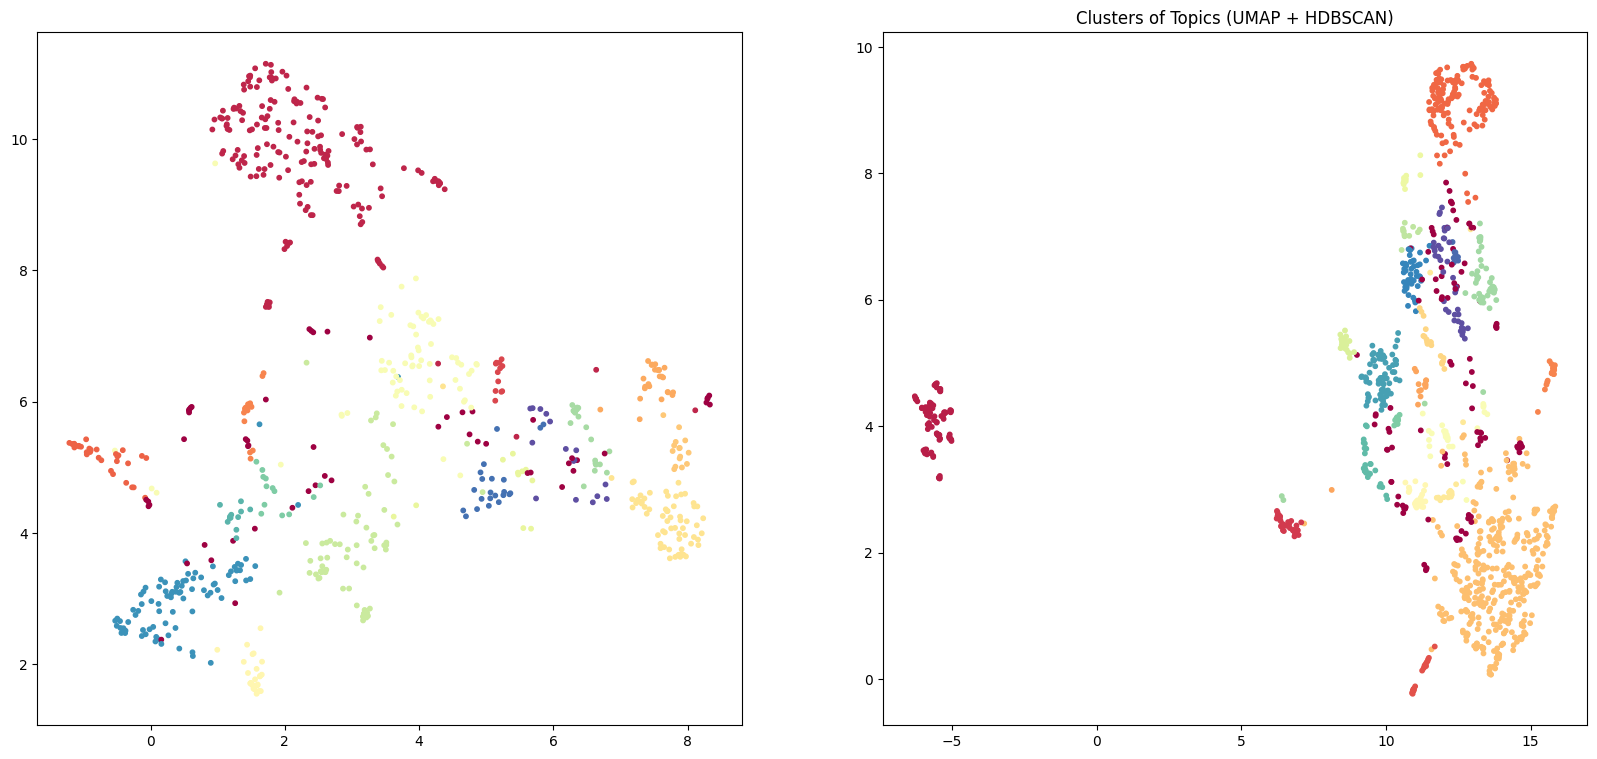

In [30]:
# Reduce embeddings to 2D for visualization
reduced_embeddings_2d = [
    umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings[i])
    for i in range(2)
]

# Plot clusters
fig, ax = plt.subplots(1, 2,figsize=(20,9))

for n,i in enumerate(ax):
    #plt.figure()
    i.scatter(
        reduced_embeddings_2d[n][:, 0],
        reduced_embeddings_2d[n][:, 1],
        c=clusters[n],
        cmap='Spectral',
        s=10
    )
plt.title(f'Clusters of Topics (UMAP + HDBSCAN)')
plt.show()


Onet and WP plotted together. Embedings normalized #todo: rethink if its a good representation

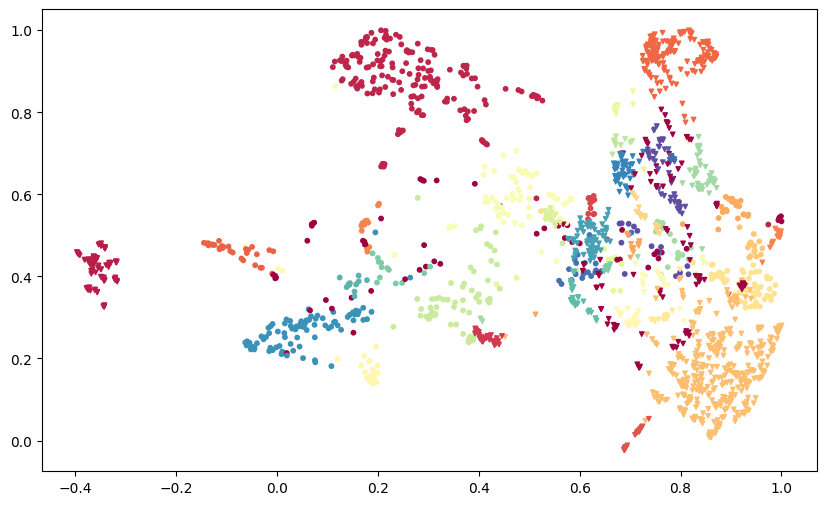

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(
    reduced_embeddings_2d[0][:, 0]/max(reduced_embeddings_2d[0][:, 0]),
    reduced_embeddings_2d[0][:, 1]/max(reduced_embeddings_2d[0][:, 1]),
    c=clusters[0],
    cmap='Spectral',
    marker = "o",
    s=10
    )
plt.scatter(
    reduced_embeddings_2d[1][:, 0]/max(reduced_embeddings_2d[1][:, 0]),
    reduced_embeddings_2d[1][:, 1]/max(reduced_embeddings_2d[1][:, 1]),
    c=clusters[1],
    cmap='Spectral',
    marker = "v",
    s=10
    )

# 9.Display Topics

In [32]:

# Step 6: Display results
results = [1,2]
for i in range(2):
  results[i] = pd.DataFrame({'Document': documents[i], 'Cluster': clusters[i]})
  print(f"Topic Modeling Results for Dataset {i}:")
  print(results[i])

  print(f"\nExtracted Topics (TF-IDF) for Dataset {i}:")
  for cluster_id, keywords in topics[i].items():
      print(f"Cluster {cluster_id}: {', '.join(keywords)}")

Topic Modeling Results for Dataset 0:
                                              Document  Cluster
0    Zmiany ws. cen energii. Nie dotyczą wszystkich...        8
1    Precyzyjne uderzenie. Ukraina zniszczyła skład...        0
2    Agenci CBA w TVP. Badają sprawę Telewizji Bieł...       15
3    Nocna tragedia na drodze. Młody mężczyzna nie ...       14
4    Zełenski ostro o Putinie: "Jest słabszy niż US...        0
..                                                 ...      ...
742  Dzisiejsze wyniki pozbawiają Orbana władzy. Co...        0
743  Tusk opublikował zdjęcie z łódki. Był z zagran...        0
744  Nacjonaliści wezmą władzę w kraju UE? Prowadzą...       -1
745  Wyniki Lotto 28.11.2024 – losowania Lotto, Lot...        8
746  Rośnie napięcie w Gruzji. Zamieszki podczas pr...        0

[747 rows x 2 columns]

Extracted Topics (TF-IDF) for Dataset 0:
Cluster 0: rosji, ukrainy, ukrainie, rosja, usa, putin, wojny, ataku, polski, rosyjskie, obrony, nato, ukraina, powiedział, ukra

# 10. Calculatecosine simmilarity based on avarage articles embedings containing keywords from topic

In [33]:
def calculate_cosine_similarity(topics_WP, topics_ON, cluster_assignments_WP, cluster_assignments_ON, embeddings_WP, embeddings_ON,media1="WP",media2="ON"):
    """
    #Calculates cosine similarity between topic clusters from two datasets (WP and ON).

    Args:
        topics_WP: Dictionary of topics for WP dataset (cluster_id -> keyword list).
        topics_ON: Dictionary of topics for ON dataset (cluster_id -> keyword list).
        cluster_assignments_WP: Dictionary mapping document indices to WP cluster IDs.
        cluster_assignments_ON: Dictionary mapping document indices to ON cluster IDs.
        embeddings_WP: List of embeddings for WP dataset.
        embeddings_ON: List of embeddings for ON dataset.
        media1: Name of the first media dataset.
        media2: Name of the second media dataset.

    Returns:
        A dictionary where keys are topic pairs (WP_cluster_id, ON_cluster_id)
        and values are their cosine similarity.
    """
    similarity_results = {}

    # Compute average embedding for each WP cluster
    wp_cluster_embeddings = {}
    for cluster_id in topics_WP.keys():
        cluster_docs = [embeddings_WP[i] for i, c in cluster_assignments_WP.items() if c == cluster_id]
        if cluster_docs:
            wp_cluster_embeddings[cluster_id] = np.mean(cluster_docs, axis=0)

    # Compute average embedding for each ON cluster
    on_cluster_embeddings = {}
    for cluster_id in topics_ON.keys():
        cluster_docs = [embeddings_ON[i] for i, c in cluster_assignments_ON.items() if c == cluster_id]
        if cluster_docs:
            on_cluster_embeddings[cluster_id] = np.mean(cluster_docs, axis=0)

    # Compute cosine similarity between cluster embeddings
    for wp_cluster_id, wp_embedding in wp_cluster_embeddings.items():
        for on_cluster_id, on_embedding in on_cluster_embeddings.items():
            similarity = cosine_similarity([wp_embedding], [on_embedding])[0][0]
            similarity_results[(media1+str(wp_cluster_id), media2+str(on_cluster_id))] = similarity

    return similarity_results


In [34]:

# Create a dictionary where keys are document indices and values are cluster numbers
cluster_assignments_WP = {i: clusters[0][i] for i in range(len(clusters[0]))}
cluster_assignments_ON = {i: clusters[1][i] for i in range(len(clusters[1]))}

In [35]:
similarity_scores = calculate_cosine_similarity(
    topics[0], topics[1], cluster_assignments_WP, cluster_assignments_ON, embeddings[0], embeddings[1]
)
print(similarity_scores)


{('WP0', 'ON0'): np.float64(0.5244952513713365), ('WP0', 'ON1'): np.float64(0.6181134899885398), ('WP0', 'ON2'): np.float64(0.7201547448134531), ('WP0', 'ON3'): np.float64(0.6767166937480396), ('WP0', 'ON4'): np.float64(0.6787180613342345), ('WP0', 'ON5'): np.float64(0.6401382872412967), ('WP0', 'ON6'): np.float64(0.9783456793075471), ('WP0', 'ON7'): np.float64(0.6676900174010216), ('WP0', 'ON8'): np.float64(0.7818010395445985), ('WP0', 'ON9'): np.float64(0.7587893969887749), ('WP0', 'ON10'): np.float64(0.8359482135656755), ('WP0', 'ON11'): np.float64(0.6046813498701138), ('WP0', 'ON12'): np.float64(0.592934179514302), ('WP0', 'ON13'): np.float64(0.5885343055925729), ('WP0', 'ON14'): np.float64(0.7217936113275505), ('WP0', 'ON15'): np.float64(0.5785843701277129), ('WP0', 'ON16'): np.float64(0.6405881628453753), ('WP0', 'ON17'): np.float64(0.7183042971802276), ('WP0', 'ON18'): np.float64(0.6836121858567588), ('WP0', 'ON19'): np.float64(0.5765310515574105), ('WP0', 'ON20'): np.float64(0.

check simmilarity of clusters for the same media outlet

In [36]:
self_sim_WP = calculate_cosine_similarity(
    topics[0], topics[0], cluster_assignments_WP, cluster_assignments_WP, embeddings[0], embeddings[0],media1="WP",media2="WP"
)
self_sim_ON = calculate_cosine_similarity(
    topics[1], topics[1], cluster_assignments_ON, cluster_assignments_ON, embeddings[1], embeddings[1],media1="ON",media2="ON"
)

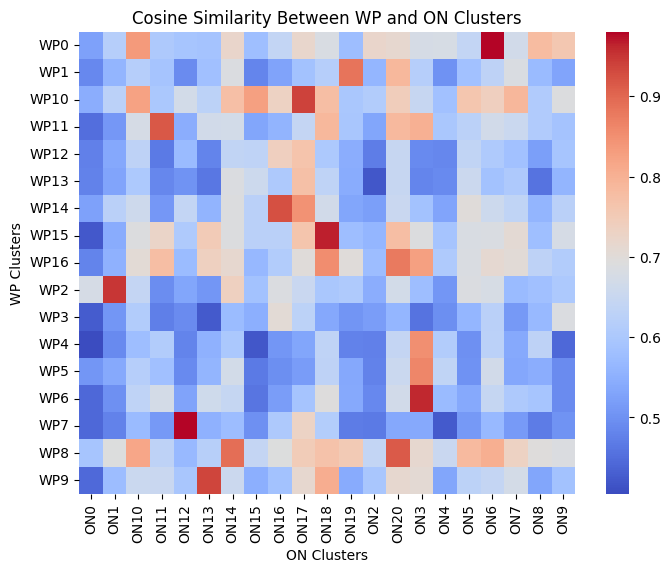

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_similarity_heatmap(similarity_results):
    """
    Plots a heatmap of cosine similarity scores between WP and ON clusters.

    Args:
        similarity_results: Dictionary with keys as (WP_cluster_id, ON_cluster_id)
                            and values as cosine similarity scores.
    """
    # Extract unique cluster IDs
    wp_clusters = sorted(set(k[0] for k in similarity_results.keys()))
    on_clusters = sorted(set(k[1] for k in similarity_results.keys()))

    # Create similarity matrix
    similarity_matrix = np.zeros((len(wp_clusters), len(on_clusters)))
    for (wp_id, on_id), similarity in similarity_results.items():
        i = wp_clusters.index(wp_id)
        j = on_clusters.index(on_id)
        similarity_matrix[i, j] = similarity

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm", xticklabels=on_clusters, yticklabels=wp_clusters)

    plt.xlabel("ON Clusters")
    plt.ylabel("WP Clusters")
    plt.title("Cosine Similarity Between WP and ON Clusters")
    plt.show()

# Example usage
plot_similarity_heatmap(similarity_scores)


Display pairs with highest simmilarities

In [38]:


def find_most_similar_articles(similarity_scores):
    """
    Finds the article pair with the highest similarity score for each article.

    Args:
        similarity_scores: A dictionary where keys are tuples (WP_cluster_id, ON_cluster_id)
                           and values are similarity scores.

    Returns:
        A dictionary where keys are WP cluster IDs and values are tuples of
        (ON cluster ID, similarity score).
    """

    most_similar_pairs = {}
    for (wp_cluster, on_cluster), score in similarity_scores.items():
        if wp_cluster not in most_similar_pairs or score > most_similar_pairs[wp_cluster][1]:
            most_similar_pairs[wp_cluster] = (on_cluster, score)

    return most_similar_pairs


# Assuming 'similarity_scores' is defined as in the provided code
most_similar = find_most_similar_articles(similarity_scores)

for wp_cluster, (on_cluster, score) in most_similar.items():
    print(f"WP Cluster {wp_cluster} has the highest similarity with ON Cluster {on_cluster} (score: {score:.4f})")
print("\n Onet clusters \n")
for on_cluster, (wp_cluster, score) in most_similar.items():
    print(f"ON Cluster {on_cluster} has the highest similarity with WP Cluster {wp_cluster} (score: {score:.4f})")

WP Cluster WP0 has the highest similarity with ON Cluster ON6 (score: 0.9783)
WP Cluster WP1 has the highest similarity with ON Cluster ON19 (score: 0.8856)
WP Cluster WP2 has the highest similarity with ON Cluster ON1 (score: 0.9507)
WP Cluster WP3 has the highest similarity with ON Cluster ON16 (score: 0.7045)
WP Cluster WP4 has the highest similarity with ON Cluster ON3 (score: 0.8504)
WP Cluster WP5 has the highest similarity with ON Cluster ON3 (score: 0.8613)
WP Cluster WP6 has the highest similarity with ON Cluster ON3 (score: 0.9610)
WP Cluster WP7 has the highest similarity with ON Cluster ON12 (score: 0.9803)
WP Cluster WP8 has the highest similarity with ON Cluster ON20 (score: 0.9150)
WP Cluster WP9 has the highest similarity with ON Cluster ON13 (score: 0.9366)
WP Cluster WP10 has the highest similarity with ON Cluster ON17 (score: 0.9382)
WP Cluster WP11 has the highest similarity with ON Cluster ON11 (score: 0.9160)
WP Cluster WP12 has the highest similarity with ON Clus

In [39]:
similarity_scores.keys()

dict_keys([('WP0', 'ON0'), ('WP0', 'ON1'), ('WP0', 'ON2'), ('WP0', 'ON3'), ('WP0', 'ON4'), ('WP0', 'ON5'), ('WP0', 'ON6'), ('WP0', 'ON7'), ('WP0', 'ON8'), ('WP0', 'ON9'), ('WP0', 'ON10'), ('WP0', 'ON11'), ('WP0', 'ON12'), ('WP0', 'ON13'), ('WP0', 'ON14'), ('WP0', 'ON15'), ('WP0', 'ON16'), ('WP0', 'ON17'), ('WP0', 'ON18'), ('WP0', 'ON19'), ('WP0', 'ON20'), ('WP1', 'ON0'), ('WP1', 'ON1'), ('WP1', 'ON2'), ('WP1', 'ON3'), ('WP1', 'ON4'), ('WP1', 'ON5'), ('WP1', 'ON6'), ('WP1', 'ON7'), ('WP1', 'ON8'), ('WP1', 'ON9'), ('WP1', 'ON10'), ('WP1', 'ON11'), ('WP1', 'ON12'), ('WP1', 'ON13'), ('WP1', 'ON14'), ('WP1', 'ON15'), ('WP1', 'ON16'), ('WP1', 'ON17'), ('WP1', 'ON18'), ('WP1', 'ON19'), ('WP1', 'ON20'), ('WP2', 'ON0'), ('WP2', 'ON1'), ('WP2', 'ON2'), ('WP2', 'ON3'), ('WP2', 'ON4'), ('WP2', 'ON5'), ('WP2', 'ON6'), ('WP2', 'ON7'), ('WP2', 'ON8'), ('WP2', 'ON9'), ('WP2', 'ON10'), ('WP2', 'ON11'), ('WP2', 'ON12'), ('WP2', 'ON13'), ('WP2', 'ON14'), ('WP2', 'ON15'), ('WP2', 'ON16'), ('WP2', 'ON17'),

Visualisation with a network graph


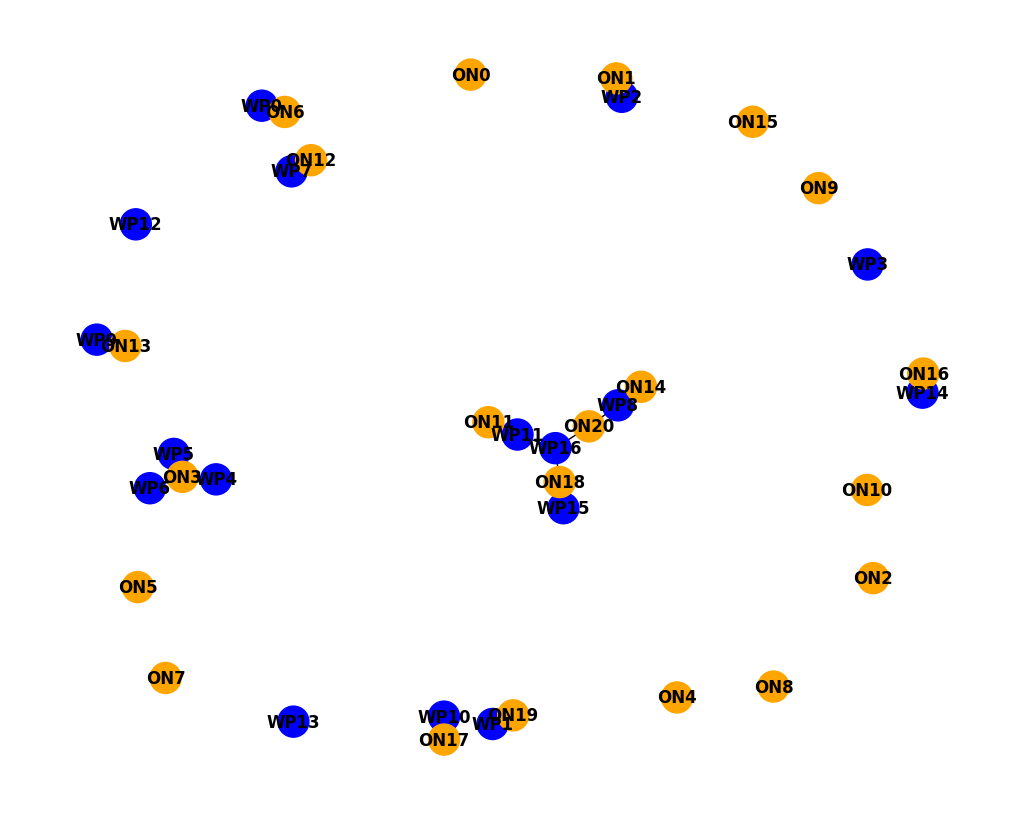

In [40]:
import matplotlib.pyplot as plt
import networkx as nx

# Your code for graph creation and adding edges
graph = nx.Graph()
wp_clusters = sorted(set(k[0] for k in similarity_scores.keys()))
on_clusters = sorted(set(k[1] for k in similarity_scores.keys()))

graph.add_nodes_from(wp_clusters, media="WP")
graph.add_nodes_from(on_clusters, media="ON")
for (wp_cluster, on_cluster), score in similarity_scores.items():
    if score >= 0.85:
        graph.add_edge(wp_cluster, on_cluster, weight=score)
for (wp_cluster, wp_clusters), score in self_sim_WP.items():
    if score >= 0.85 and score < 0.999999:
        graph.add_edge(wp_cluster, wp_clusters, weight=score)
for ( on_cluster, on_clusters), score in self_sim_ON.items():
    if score >= 0.85 and score < 0.999999:
        graph.add_edge(on_cluster, on_clusters, weight=score)
# Assign colors based on node type (WP or ON)
color_map = []
for node in graph.nodes():
    if graph.nodes[node]['media'] == "WP":
        color_map.append('blue')  # You can change 'blue' to any color you like for WP
    else:
        color_map.append('orange')  # You can change 'orange' to any color you like for ON

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph, weight = "weight", k=100)
nx.draw(graph, node_color=color_map, with_labels=True, font_weight='bold', node_size=500)

plt.show()